In [ ]:
!pip install keras

#Preparing and setting up data

In [ ]:
import io
import pandas as pd
import numpy as np
import scipy as sci

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from keras.optimizers import SGD
#from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
!pip install --user seaborn
!pip install --user statsmodels

In [ ]:
#paths to CSV data
#pathDA = '/green-thai-curry-sales(1).csv'
#pathDB = '/vegetable-korma-curry-sales(1).csv'

#READ CSVs
df_DA = pd.read_csv('/green-thai-curry-sales (1).csv')
df_DB = pd.read_csv('/vegetable-korma-curry-sales (1).csv')

print(df_DA.shape)
print(df_DA.info())

print(df_DB.shape)
print(df_DB.info())
#output shows there is no missing data

#la

(3650, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None
(3650, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None


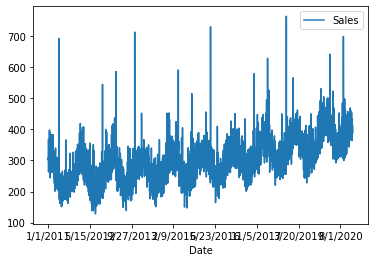

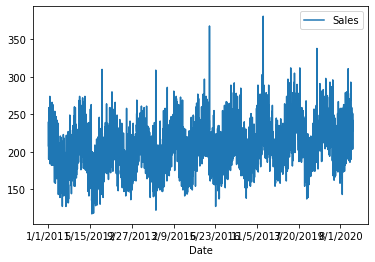

In [ ]:
#plot DA and DB
#DATE  SALES
df_DA.plot(x='Date',y='Sales')
plt.show()

df_DB.plot(x='Date',y='Sales')
plt.show()

In [ ]:
df_DA.describe()

,Sales
count,3650.000000
mean,295.181918
std,68.159440
min,128.000000
25%,247.000000
50%,288.000000
75%,338.000000
max,764.000000


In [ ]:
#checking skewness
print(df_DA['Sales'].skew())
df_DA['Sales'].describe()
#this shows an appro[iate skewness but the outliers remain, not a good approach

0.7978504996071238


count    3650.000000
mean      295.181918
std        68.159440
min       128.000000
25%       247.000000
50%       288.000000
75%       338.000000
max       764.000000
Name: Sales, dtype: float64

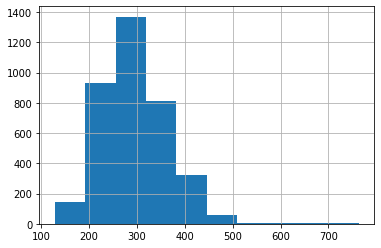

In [ ]:
df_DA.Sales.hist()
#outliers can be tected above the 500 mark

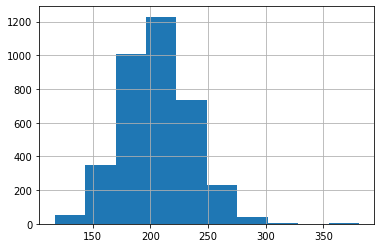

In [ ]:
df_DB.Sales.hist()

In [ ]:
#IQR approach
Q1 = df_DA.quantile(0.25)
Q3 = df_DA.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Sales    91.0
dtype: float64


(3622, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


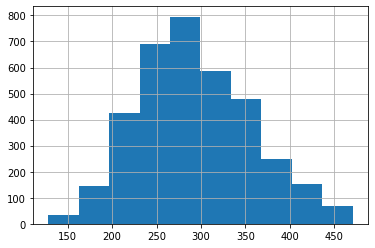

In [ ]:
#IQR Score approach
df_outA = df_DA[~((df_DA < (Q1 - 1.5 * IQR)) |(df_DA > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_outA.shape)

df_outA.Sales.hist()

#this method seems the best

Sales    39.0
dtype: float64
(3612, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


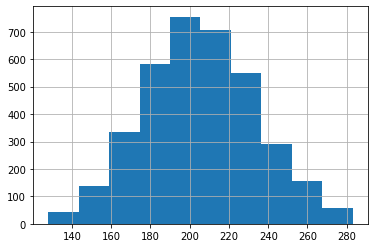

In [ ]:
#IQR approach for data B
Q1B = df_DB.quantile(0.25)
Q3B = df_DB.quantile(0.75)
IQRB = Q3B - Q1B
print(IQRB)

#IQR Score approach
df_outB = df_DB[~((df_DB < (Q1B - 1.5 * IQRB)) |(df_DB > (Q3B + 1.5 * IQRB))).any(axis=1)]
print(df_outB.shape)

df_outB.Sales.hist()

#this method seems the best

In [ ]:
#add lagging here
#lagging A
df_outA.index = df_outA.index + 1 #Initialize the index at 1
df_outB.index = df_outB.index +1

# Lag the data frame
data_A = pd.concat([df_outA.Sales.shift(1), df_outA.Sales.shift(2), df_outA.Sales.shift(3), df_outA.Sales], axis=1)
data_A.columns = ['x1','x2', 'x3' ,'y']
data_A = data_A.iloc[4:,]
data_A.head()

#repeat for B
data_B = pd.concat([df_outB.Sales.shift(1), df_outB.Sales.shift(2), df_outB.Sales.shift(3), df_outB.Sales], axis=1)
data_B.columns = ['x1','x2', 'x3', 'y']
data_B = data_B.iloc[4:,]
data_B.head()

,x1,x2,x3,y
5,190.0,206.0,240.0,228
6,228.0,190.0,206.0,235
7,235.0,228.0,190.0,208
8,208.0,235.0,228.0,229
9,229.0,208.0,235.0,259


In [ ]:
#Split DA for training
trainA = data_A[:int(data_A.shape[0]*0.85)]
testA = data_A[int(data_A.shape[0]*0.85):]

# Clean data in case of missing data
data_A= data_A.dropna()
trainA = trainA.dropna()
testA = testA.dropna()


In [ ]:
#split DB for training
trainB = data_B[:int(data_B.shape[0]*0.85)]
testB = data_B[int(data_B.shape[0]*0.85):]
# Clean data in case of missing data
data_B= data_B.dropna()
trainB = trainB.dropna()
testB = testB.dropna()

In [ ]:
# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
ytrainA_min = float(trainA.min()['y'])
ytrainA_max = float(trainA.max()['y'])
ytrainA_range = ytrainA_max - ytrainA_min

ytestA_min = float(testA.min()['y'])
ytestA_max = float(testA.max()['y'])
ytestA_range = ytestA_max - ytestA_min

In [ ]:
# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
ytrainB_min = float(trainB.min()['y'])
ytrainB_max = float(trainB.max()['y'])
ytrainB_range = ytrainB_max - ytrainB_min

ytestB_min = float(testB.min()['y'])
ytestB_max = float(testB.max()['y'])
ytestB_range = ytestB_max - ytestB_min

In [ ]:
# Normalize the data frameS for sets A and B
def scale(data_A):
    scaled_dataA = data_A.copy()
    for column in data_A.columns: 
      scaled_dataA[column] = (data_A[column] - data_A[column].min()) / (data_A[column].max() - data_A[column].min())
    return scaled_dataA

In [ ]:
# Normalize the data frameS for sets A and B
def scale(data_B):
    scaled_dataB = data_B.copy()
    for column in data_B.columns: 
      scaled_dataB[column] = (data_B[column] - data_B[column].min()) / (data_B[column].max() - data_B[column].min())
    return scaled_dataB

In [ ]:
# Scale back the data frame
def scale_back_A(data_A, data_A_min, data_A_range):
    data_A_ = data_A.copy()
    data_A_.head()
    for column in data_A_.columns: 
        data_A_[column] = (data_A_range) * data_A_[column] + data_A_min
    return data_A

In [ ]:
# Scale back the data frame B
def scale_back_B(data_B, data_B_min, data_B_range):
    data_B_ = data_B.copy()
    data_B_.head()
    for column in data_B_.columns: 
        data_B_[column] = (data_B_range) * data_B_[column] + data_B_min
    return data_B

In [ ]:
# Normalize the train data in the range of 0-1
train_A = scale(trainA)
train_B = scale(trainB)

In [ ]:
# Normalize the test data in the range of 0-1
test_A= scale(testA)
test_B=scale(testB)

In [ ]:
# Separate the input (x) and output (y)
n_A = train_A.columns                                    #column labels
xtrain_A = train_A.filter(items = ['x1','x2','x3'])  #input of the training set
ytrain_A = train_A.filter(items = ['y'])                    #output of the training set

xtest_A = test_A.filter(items = ['x1','x2','x3'])  #input of the test set
ytest_A = test_A.filter(items = ['y'])                    #output of the test set

ytest_A.head()


,y
3100,0.168724
3101,0.213992
3102,0.193416
3103,0.201646
3104,0.086420


In [ ]:
# Separate the input (x) and output (y)
n_B = train_B.columns                                    #column labels
xtrain_B = train_B.filter(items = ['x1','x2','x3'])  #input of the training set
ytrain_B = train_B.filter(items = ['y'])                    #output of the training set

xtest_B = test_B.filter(items = ['x1','x2','x3'])  #input of the test set
ytest_B = test_B.filter(items = ['y'])                    #output of the test set

ytest_B.head()


,y
3106,0.166667
3107,0.305556
3108,0.486111
3109,0.354167
3110,0.388889


#Modelling for A

#3 Neurons A

In [ ]:
# Train a neural network model
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
model_A = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags)
# and the RELU activation function
model_A.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with n neurons
# and the sigmoid activation function
model_A.add(Dense(3, activation='sigmoid'))

# Then add the output layer with 1 neuron
# and a linear activation function
model_A.add(Dense(1))

#model.build((None, 3))
model_A.summary()
print(model_A.count_params())

opt = tf.optimizers.Adam(learning_rate=0.0005)
print("")
print("Generating model ...")
# fix random seed for reproducibility
seed = 1
xtrain_for_parameter_fitting, x_validation, ytrain_for_parameter_fitting, y_validation = train_test_split(xtrain_A, ytrain_A, test_size=0.3, random_state=seed)

model_A.compile(loss='mse', optimizer=opt, metrics=['mean_squared_error'])
#history = model.fit(x=xtrain,y=ytrain, epochs=200, validation_split=0.3, verbose=0)
history = model_A.fit(x=xtrain_for_parameter_fitting,y=ytrain_for_parameter_fitting, epochs=200, validation_data=(x_validation,y_validation), verbose=0)


print("Model generation completed")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
28

Generating model ...
Model generation completed


#5 Neurons A


In [ ]:
# code here


#7 Neurons A

In [ ]:
#code

#9 Neurons A

In [ ]:
#code

# A Model generation section above, plotting of a selected model below


Final loss value in training set:  0.013563853688538074
Final loss value in validation set:  0.013923890888690948


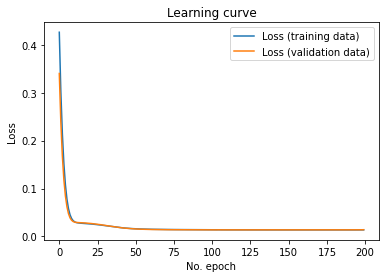

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Final loss value in training set: ", loss[-1])
print("Final loss value in validation set: ", val_loss[-1])

# Plot learning curve
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

#Calculating predictions from a model

In [ ]:
# Use the model to calculate predictions for the train set
y_pred = model_A.predict(xtrain_for_parameter_fitting)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 

In [ ]:
# Scale back the predictions and original values
y_pred_rescaled = scale_back_A(pd.DataFrame(y_pred), ytrainA_min, ytrainA_range)
y_pred_rescaled.columns =['y'] 
y_train_rescaled = scale_back_A(pd.DataFrame(ytrain_for_parameter_fitting), ytrainA_min, ytrainA_range)
y_train_rescaled.head()

,y
1317,0.323353
342,0.386228
2194,0.562874
2275,0.595808
2347,0.482036


In [ ]:
# r-squared
r2_squared_A = r2_score(y_train_rescaled, y_pred_rescaled)
print('R-squared A score of the train set:', round(r2_squared_A,4))

# mean squared error
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the train set:', round(rmse,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num = model_A.count_params()
print("Total number of parameters: ", param_num)
no_data_points = xtrain_for_parameter_fitting.shape[0]
aic = no_data_points * np.log(mse) + 2*param_num
print("Akaike Information Criterion:", round(aic, 4))

# Corrected AIC
aic_corrected = aic + \
                2*param_num*(param_num+1)/(no_data_points - param_num -1)
print("Corrected Akaike Information Criterion:", round(aic_corrected, 4))

R-squared A score of the train set: 0.5343
Root mean squared error of the train set: 0.1168
Total number of parameters:  28
Akaike Information Criterion: -9184.7414
Corrected Akaike Information Criterion: -9183.9764


In [ ]:
# Use the model to calculate predictions for the test set
y_pred_A = model_A.predict(xtest_A)

y_pred_A_df = pd.DataFrame(y_pred)
y_pred_A_df.columns =['y'] 
y_pred_A_df.head()

,y
0,0.414801
1,0.472785
2,0.517982
3,0.682251
4,0.475919


In [ ]:
# Scale back the predictions and original values for the test set
y_pred_rescaled_A = scale_back_A(pd.DataFrame(y_pred_A), ytestA_min, ytestA_range)
y_pred_rescaled_A.columns =['y'] 
y_test_rescaled_A = scale_back_A(pd.DataFrame(ytest_A), ytestA_min, ytestA_range)
y_test_rescaled_A.head()

,y
3100,0.168724
3101,0.213992
3102,0.193416
3103,0.201646
3104,0.086420


In [ ]:
# r-squared with test set
r2_squared_A = r2_score(y_test_rescaled_A, y_pred_rescaled_A)
print('R-squared score of the test set:', round(r2_squared_A,4))

# mean squared error with the test set
mse_A = mean_squared_error(y_test_rescaled_A, y_pred_rescaled_A)
rmse_A= np.sqrt(mse_A)
print('Root mean squared error of the test set:', round(rmse_A,4))

R-squared score of the test set: 0.47
Root mean squared error of the test set: 0.1485


Text(0.5, 1.0, 'Scatter plot of predicted vs actual data')

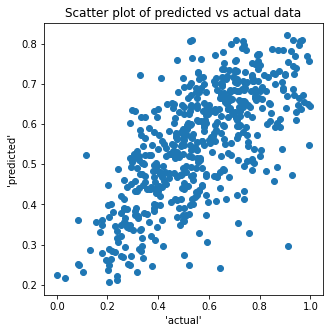

In [ ]:
# Generate a scatter plot of predicted vs actual data
plt.figure(figsize=(5,5))
plt.scatter(x = y_test_rescaled_A, y = y_pred_rescaled_A)
plt.xlabel("'actual'")
plt.ylabel("'predicted'")
plt.title("Scatter plot of predicted vs actual data")

In [ ]:
# Add a time column for plotting purposes
y_test_rescaled_A['time'] = y_test_rescaled_A.index
y_test_rescaled_A = y_test_rescaled_A.sort_values(by=['time'])
y_actual_A = pd.DataFrame(y_test_rescaled_A['y'])
y_actual_A.reset_index(drop=True, inplace=True)

y_pred_rescaled_A['time'] = y_test_rescaled_A.index
y_pred_rescaled_A = y_pred_rescaled_A.sort_values(by=['time'])
y_hat_A = pd.DataFrame(y_pred_rescaled_A['y'])
y_hat_A.reset_index(drop=True, inplace=True)

time_A = y_test_rescaled_A['time']

# To export the predictions and test values to a CSV file
df_outA.to_csv(r'Predictions_and_test_A.csv', index = False)
y_test_rescaled_A.to_csv(r'ytest.csv', index = False)
y_pred_rescaled_A.to_csv(r'yhat.csv', index = False)

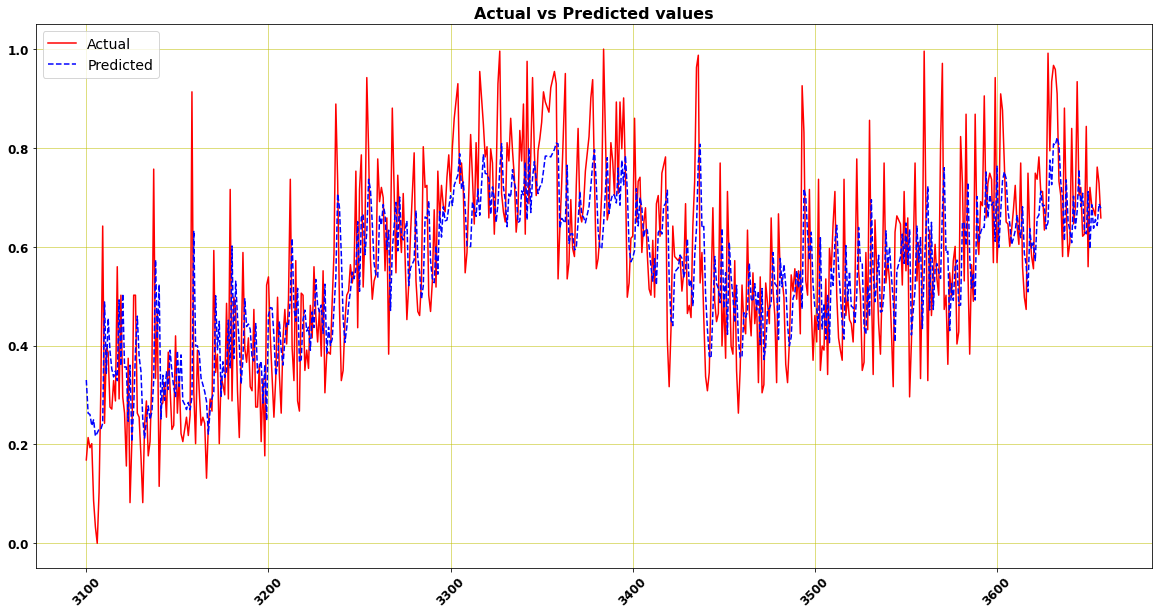

In [ ]:

plt.figure(figsize=(20, 10))
plt.plot(time_A, y_actual_A, linestyle='solid', color='r')
plt.plot(time_A, y_hat_A, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Actual vs Predicted values', weight='bold', fontsize=16)
#plt.ylabel('demand', weight='bold', fontsize=14)
#plt.xlabel('time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()


#Modelling for B

## 3 Neurons B

## 5 Neurons B

##7 Neurons B

## 9 Neurons B

# B Model generation section above, plotting of a selected model below

#B Calculating predictions from a model